In [4]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [5]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

# Super resolution

## Build Dataset

In [138]:
il = ImageItemList.from_folder(path_hr)

In [179]:
def resize_one(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [18]:
il.items[5].name

'beagle_63.jpg'

In [ ]:
## Create smaller images
parallel(resize_one, il.items)

In [14]:
bs, size = 32, 128
arch = models.resnet34

In [15]:
src = ImageImageList.from_folder(path_lr).random_split_by_pct(.1, seed=42)

In [19]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c=3
    return data

In [20]:
data = get_data(bs,size)

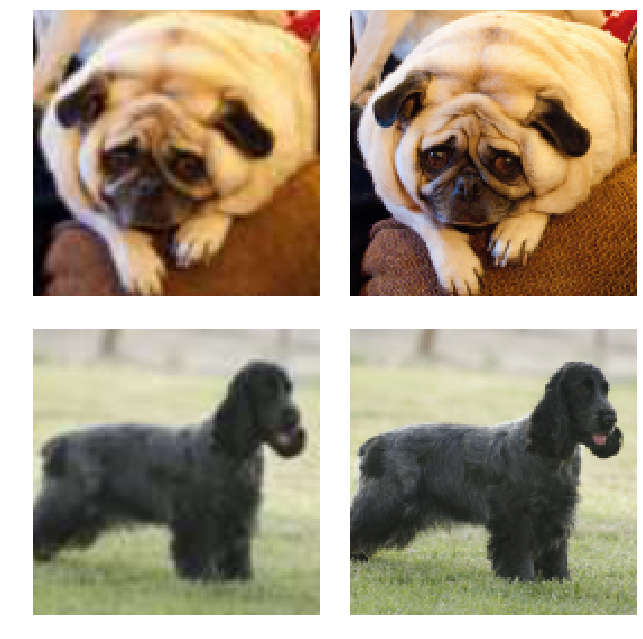

In [21]:
data.show_batch(ds_type = DatasetType.Valid, rows=2, figsize=(9,9))

## Gram matrix

In [32]:
t = data.valid_ds[0][1].data # tensor of target image
t.shape

torch.Size([3, 128, 128])

In [33]:
t = torch.stack([t,t]) # stack 2 itentical tensor in one
t.shape

torch.Size([2, 3, 128, 128])

In [44]:
t.view(2,3,-1).shape

torch.Size([2, 3, 16384])

In [41]:
t.view(2,3,-1).transpose(1,2).shape

torch.Size([2, 16384, 3])

In [42]:
3*128*128

49152

In [38]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n,c,-1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [40]:
gram_matrix(t).shape

torch.Size([2, 3, 3])

## Setup "Loss pretrained CNN" for Loss features

In [47]:
base_loss = F.l1_loss

In [48]:
# Set pretrained CNN as loss NN func, not training, nograds
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:08<00:00, 64760991.53it/s]


In [50]:
children(vgg_m) # list model layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 Conv2d(2

In [53]:
# get layers's indexes of activaitons before normalization layer
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
print('List of activations pre-normalization')
blocks, [vgg_m[i] for i in blocks]

List of activations pre-normalization


([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [123]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel,']+[f'feat_{i}' for i in range(len(layer_ids))
                            ] + [f'gram_{i}' for i in range(len(layer_ids))]
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    def forward(self, input, target):
        # run input and target through pretrained model
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        
        self.feat_losses = [ base_loss(input, target) ]
        self.feat_losses += [base_loss(f_in, f_out)*w 
                             for f_in,f_out,w in zip(in_feat,out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))* w**2 * 5e3
                            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    def __del__(self): self.hooks.remove()
        
        

In [87]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train model

In [60]:
wd = 1e-3

In [92]:
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                    blur=True, norm_type=NormType.Weight)

In [93]:
gc.collect()

7115

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


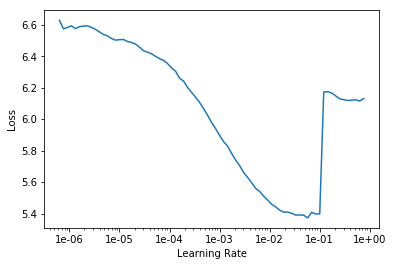

In [94]:
learn.lr_find()
learn.recorder.plot()

In [95]:
lr = 1e-3

In [129]:
def do_fit(save_name, lrs=slice(lr), pct_start=.9):
    learn.fit_one_cycle(1, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,"pixel,",feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.855221,3.744075,0.142365,0.230070,0.315998,0.224918,0.554787,1.211101,1.064835
2,3.742517,3.591906,0.145202,0.227107,0.306153,0.215369,0.523151,1.151138,1.023786
3,3.658660,3.497712,0.143892,0.224722,0.300207,0.210639,0.499985,1.117561,1.000707
4,3.626143,3.445767,0.144106,0.225434,0.297661,0.205656,0.488152,1.106290,0.978469
5,3.570787,3.418157,0.145977,0.224655,0.295135,0.204510,0.481147,1.094626,0.972107
6,3.511753,3.396111,0.140757,0.219188,0.290140,0.202171,0.490453,1.094977,0.958425
7,3.493466,3.362858,0.143875,0.219325,0.288616,0.200323,0.475422,1.078860,0.956437
8,3.465198,3.336252,0.139925,0.221633,0.290187,0.199925,0.461370,1.072394,0.950817
9,3.425809,3.262043,0.137629,0.217080,0.283182,0.194742,0.451777,1.048254,0.929381
10,3.341463,3.177652,0.135788,0.215270,0.277833,0.189411,0.435613,1.021696,0.902042


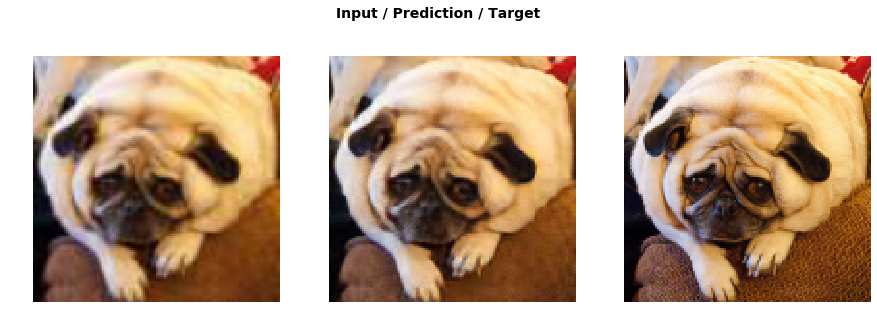

In [108]:
do_fit('1a', slice(lr*10))

### Unfreeze

In [115]:
learn.unfreeze()

epoch,train_loss,valid_loss,"pixel,",feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.303113,3.169655,0.135932,0.214882,0.277133,0.189026,0.432909,1.019319,0.900454
2,3.324641,3.159667,0.136976,0.215003,0.276962,0.188396,0.429642,1.016188,0.896500
3,3.296488,3.154856,0.136624,0.214179,0.276314,0.188218,0.428890,1.014451,0.896180
4,3.310586,3.158086,0.136813,0.214262,0.276414,0.188141,0.431686,1.016549,0.894221
5,3.278582,3.136727,0.136290,0.214078,0.275516,0.187490,0.422210,1.009107,0.892036


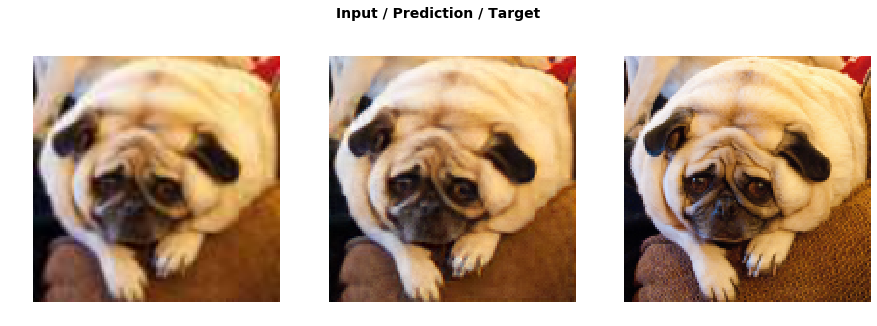

In [117]:
do_fit('1b', slice(1e-5, lr))

In [121]:
data = get_data(12, size*2)

In [124]:
learn.data = data
learn.freeze()
gc.collect()

0

In [125]:
learn.load('1b')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (6651 items)
[Image (3, 500, 460), Image (3, 900, 600), Image (3, 443, 450), Image (3, 500, 355), Image (3, 500, 329)]...
Path: /storage/oxford-iiit-pet/small-96
x: ImageImageList (6651 items)
[Image (3, 104, 96), Image (3, 144, 96), Image (3, 96, 97), Image (3, 135, 95), Image (3, 145, 96)]...
Path: /storage/oxford-iiit-pet/small-96;

Valid: LabelList
y: ImageItemList (739 items)
[Image (3, 500, 482), Image (3, 333, 500), Image (3, 375, 500), Image (3, 375, 500), Image (3, 334, 500)]...
Path: /storage/oxford-iiit-pet/small-96
x: ImageImageList (739 items)
[Image (3, 99, 96), Image (3, 96, 144), Image (3, 96, 128), Image (3, 96, 128), Image (3, 96, 143)]...
Path: /storage/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

epoch,train_loss,valid_loss,"pixel,",feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.180838,2.166918,0.166788,0.259959,0.292128,0.153197,0.362191,0.570175,0.362481


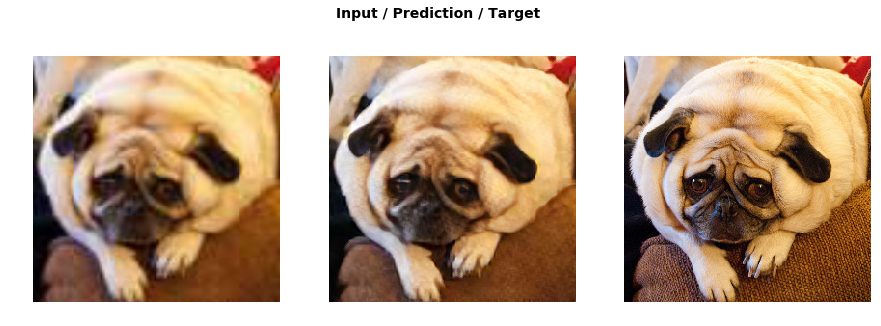

In [130]:
do_fit('2a')

In [132]:
learn.unfreeze()

epoch,train_loss,valid_loss,"pixel,",feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.160833,2.159785,0.166326,0.260144,0.291741,0.152655,0.359769,0.568904,0.360246


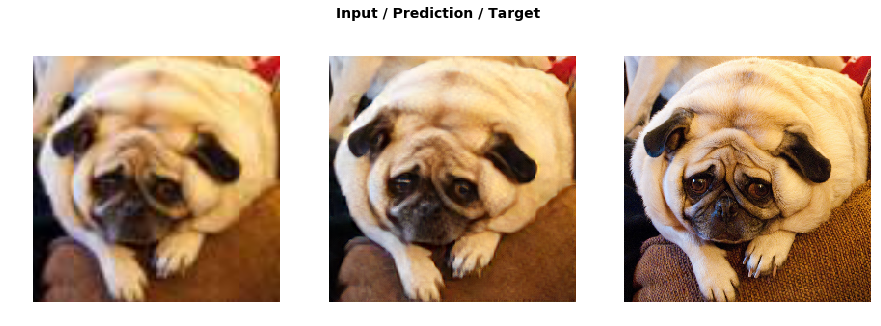

In [133]:
do_fit('2b', slice(1e-6, 1e-4), pct_start=.3)

## Test

In [157]:
learn = None
gc.collect()

0

In [158]:
path_mr.ls()

[PosixPath('/storage/oxford-iiit-pet/small-256/Sphynx_179.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/Russian_Blue_12.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/Ragdoll_148.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/chihuahua_18.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/beagle_127.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/beagle_63.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/Abyssinian_215.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/pug_171.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/miniature_pinscher_90.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/pug_54.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/Bombay_145.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/pug_124.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/japanese_chin_167.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/Sphynx_71.jpg'),
 PosixPath('/storage/oxford-iiit-pet/small-256/chihuahua_163.jpg'),
 Pos

In [159]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [160]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(1280,1600),tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [161]:
learn.load('2b')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (6651 items)
[Image (3, 500, 460), Image (3, 900, 600), Image (3, 443, 450), Image (3, 500, 355), Image (3, 500, 329)]...
Path: /storage/oxford-iiit-pet/small-96
x: ImageImageList (6651 items)
[Image (3, 278, 256), Image (3, 384, 256), Image (3, 255, 260), Image (3, 360, 256), Image (3, 389, 256)]...
Path: /storage/oxford-iiit-pet/small-96;

Valid: LabelList
y: ImageItemList (739 items)
[Image (3, 500, 482), Image (3, 333, 500), Image (3, 375, 500), Image (3, 375, 500), Image (3, 334, 500)]...
Path: /storage/oxford-iiit-pet/small-96
x: ImageImageList (739 items)
[Image (3, 265, 256), Image (3, 256, 384), Image (3, 256, 341), Image (3, 256, 341), Image (3, 256, 383)]...
Path: /storage/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [162]:
learn.data = data_mr

In [165]:
fn = data_mr.valid_ds.x.items[0] ; fn

PosixPath('/storage/oxford-iiit-pet/small-256/pug_32.jpg')

In [166]:
img = open_image(fn); img.shape

torch.Size([3, 265, 256])

In [167]:
p, img_hr, b = learn.predict(img)

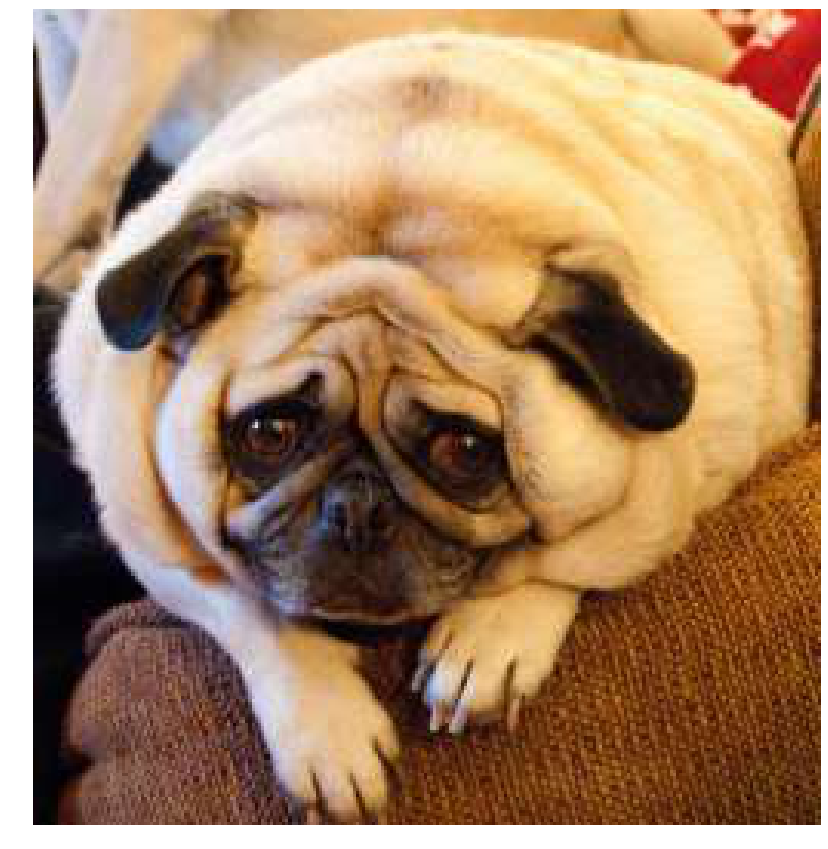

In [168]:
show_image(img, figsize=(18,15), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


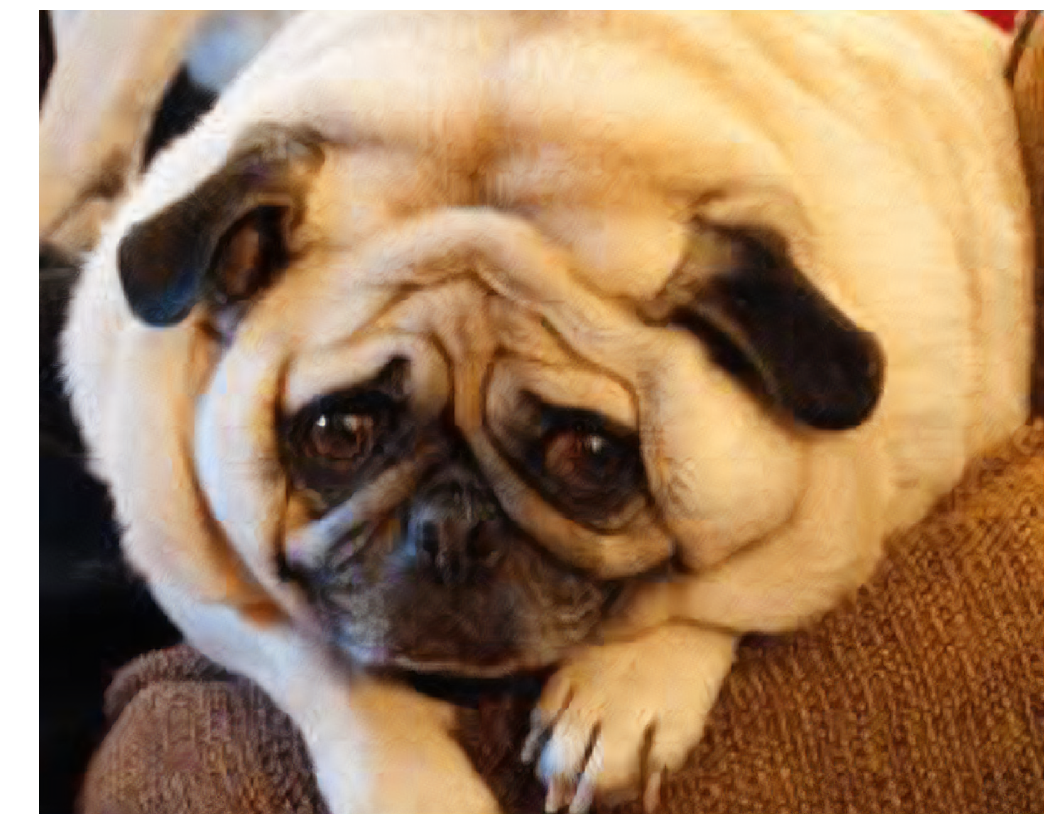

In [169]:
Image(img_hr).show(figsize=(18,15))

## END